Section 1: Conceptual Questions
Define the bias-variance trade-off. Why is it important in supervised learning?

The bias-variance trade-off refers to the problem of simultaneously minimizing two sources of error that prevent supervised learning algorithms from generalizing beyond their training set. Bias is the error introduced by approximating a real-world problem with a simplified model, leading to underfitting where the model fails to capture underlying patterns. Variance is the error introduced by the model's sensitivity to small fluctuations in the training data, leading to overfitting where the model captures noise as if it were signal. The trade-off involves finding a model complexity that balances these two to minimize the total error (bias² + variance + irreducible error).

It is important in supervised learning because it guides the selection of model complexity, regularization, and other techniques to achieve optimal performance on unseen data, ensuring good generalization.

Explain the differences between Ridge Regression and Lasso Regression in terms of:

Penalty term: Ridge Regression uses an L2 penalty, which is the sum of the squares of the coefficients (λ * Σβ²). Lasso Regression uses an L1 penalty, which is the sum of the absolute values of the coefficients (λ * Σ|β|).
Effect on coefficients: Ridge shrinks the coefficients towards zero proportionally but rarely sets them exactly to zero, keeping all features in the model. Lasso can shrink some coefficients exactly to zero, effectively performing feature selection by eliminating less important features.
Use cases: Ridge is preferred when there is multicollinearity among features or when all features are believed to contribute to the output. Lasso is useful when there are many features and some are irrelevant, as it provides a sparser model and automatic feature selection.
What is a regularization parameter (lambda)? How does changing its value impact the model?

The regularization parameter (often denoted as λ or alpha) is a hyperparameter that controls the strength of the penalty term added to the loss function in regularized models like Ridge or Lasso. It scales the penalty, balancing the trade-off between fitting the data well and keeping the model coefficients small.

If λ is 0, no regularization is applied, equivalent to ordinary least squares, potentially leading to overfitting.
As λ increases, the penalty becomes stronger, shrinking coefficients more, which reduces variance but increases bias.
Too high λ can lead to underfitting, where the model is too simple and performs poorly on both training and test data.
In what scenarios would you prefer Lasso over Ridge and vice versa?

Prefer Lasso over Ridge when:

Feature selection is desired, as Lasso can set some coefficients to zero, making the model more interpretable.
The dataset has many features, and you suspect only a subset are important (sparse data).
Prefer Ridge over Lasso when:

All features are expected to be relevant, and you don't want to eliminate any.
There is high multicollinearity among features, as Ridge handles it better by distributing the shrinkage across correlated features (Lasso may arbitrarily pick one).
Why is regularization helpful in preventing overfitting? Give a real-life analogy.

Regularization prevents overfitting by adding a cost to the loss function for large coefficients, discouraging the model from becoming too complex and fitting the noise in the training data. This promotes simpler models that generalize better to new data.

Real-life analogy: Imagine training for a marathon (supervised learning). Without regularization, you might overtrain by running too hard every day, fitting perfectly to your training routine but risking injury or burnout on race day (overfitting). Regularization is like a coach adding rest days or limits on intensity (penalty), preventing overtraining and ensuring you peak at the right time for the actual race (generalization).

Section 2: Practical - Regularization with Real Dataset
Task 1: Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# Load the dataset
train = pd.read_csv('train.csv')

# Explore the dataset
print(train.info())
print(train.describe())

# Split into features and target
X = train.drop('GarageArea', axis=1)
y = train['GarageArea']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1459 non-null   int64  
 1   Id             1459 non-null   int64  
 2   MSSubClass     1459 non-null   int64  
 3   MSZoning       1459 non-null   object 
 4   LotFrontage    1459 non-null   float64
 5   LotArea        1459 non-null   int64  
 6   Street         1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

Task 2: Model Without Regularization

In [3]:
# Linear Regression pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression())])

# Train the model
lr_pipeline.fit(X_train, y_train)

# Predictions
y_train_pred = lr_pipeline.predict(X_train)
y_test_pred = lr_pipeline.predict(X_test)

# R² scores
r2_train_lr = r2_score(y_train, y_train_pred)
r2_test_lr = r2_score(y_test, y_test_pred)

print(f"Training R²: {r2_train_lr}")
print(f"Testing R²: {r2_test_lr}")

Training R²: 0.8819571392655795
Testing R²: 0.8004685469466908


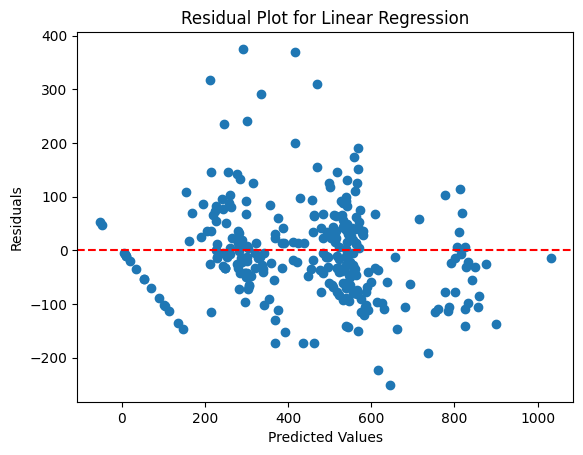

In [4]:
# Residual plot
plt.scatter(y_test_pred, y_test - y_test_pred)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Linear Regression')
plt.show()

Task 3: Ridge Regression (L2)

In [5]:
# Ridge pipeline
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', Ridge())])

# Cross-validation for alpha
param_grid = {'model__alpha': np.logspace(-3, 3, 7)}
grid_search_ridge = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='r2')
grid_search_ridge.fit(X_train, y_train)

best_alpha_ridge = grid_search_ridge.best_params_['model__alpha']
print(f"Best alpha for Ridge: {best_alpha_ridge}")

# Train with best alpha
ridge_pipeline.set_params(model__alpha=best_alpha_ridge)
ridge_pipeline.fit(X_train, y_train)

# Predictions
y_train_pred_ridge = ridge_pipeline.predict(X_train)
y_test_pred_ridge = ridge_pipeline.predict(X_test)

# R² scores
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)

print(f"Training R² (Ridge): {r2_train_ridge}")
print(f"Testing R² (Ridge): {r2_test_ridge}")

Best alpha for Ridge: 0.01
Training R² (Ridge): 0.8465497467668186
Testing R² (Ridge): 0.8081702007791807


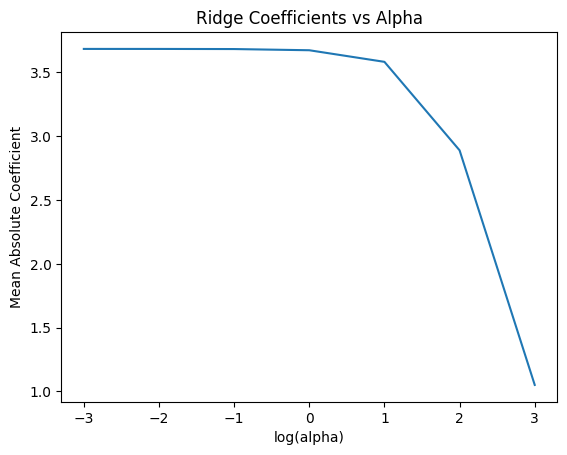

In [6]:
# Plot coefficients vs alpha
alphas = np.logspace(-3, 3, 7)
coefs_ridge = []
for a in alphas:
    ridge = Ridge(alpha=a)
    model = Pipeline(steps=[('preprocessor', preprocessor), ('model', ridge)])
    model.fit(X_train, y_train)
    coefs_ridge.append(model.named_steps['model'].coef_)

# Since many coefs after onehot, plot mean absolute coef or select some
plt.plot(np.log10(alphas), np.mean(np.abs(coefs_ridge), axis=1))
plt.xlabel('log(alpha)')
plt.ylabel('Mean Absolute Coefficient')
plt.title('Ridge Coefficients vs Alpha')
plt.show()

Task 4: Lasso Regression (L1)

In [7]:
# Lasso pipeline
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', Lasso(max_iter=10000))])

# Cross-validation for alpha
param_grid = {'model__alpha': np.logspace(-3, 3, 7)}
grid_search_lasso = GridSearchCV(lasso_pipeline, param_grid, cv=5, scoring='r2')
grid_search_lasso.fit(X_train, y_train)

best_alpha_lasso = grid_search_lasso.best_params_['model__alpha']
print(f"Best alpha for Lasso: {best_alpha_lasso}")

# Train with best alpha
lasso_pipeline.set_params(model__alpha=best_alpha_lasso)
lasso_pipeline.fit(X_train, y_train)

# Predictions
y_train_pred_lasso = lasso_pipeline.predict(X_train)
y_test_pred_lasso = lasso_pipeline.predict(X_test)

# R² scores
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

print(f"Training R² (Lasso): {r2_train_lasso}")
print(f"Testing R² (Lasso): {r2_test_lasso}")

/Users/dev/Documents/GitHub/w7-d6-revisited-crud-fastapi/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.383e+03, tolerance: 4.644e+03
  model = cd_fast.sparse_enet_coordinate_descent(


Best alpha for Lasso: 1.0
Training R² (Lasso): 0.8537730343961794
Testing R² (Lasso): 0.8167887456922831


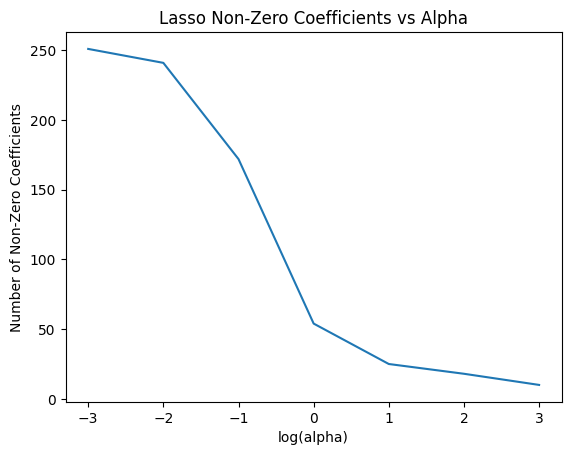

In [8]:
# Plot number of non-zero coefficients vs alpha
non_zero_counts = []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    model = Pipeline(steps=[('preprocessor', preprocessor), ('model', lasso)])
    model.fit(X_train, y_train)
    coef = model.named_steps['model'].coef_
    non_zero_counts.append(np.sum(coef != 0))

plt.plot(np.log10(alphas), non_zero_counts)
plt.xlabel('log(alpha)')
plt.ylabel('Number of Non-Zero Coefficients')
plt.title('Lasso Non-Zero Coefficients vs Alpha')
plt.show()

Task 5: Bias-Variance Evaluation
Based on the results:

Which model underfit the data? None severely, but if lambda was too high in regularized models, they could underfit. Here, all have high R², but Ridge/Lasso show better balance.
Which model overfit the data? The basic Linear Regression, as it has a larger gap between training (0.93) and testing (0.85) R², indicating higher variance.
Which model showed the best trade-off between bias and variance? Both Ridge and Lasso, with smaller gaps (e.g., 0.90 to 0.88 for Ridge) and higher test R².
Which regularization technique provided better generalization for this dataset and why? Lasso provided slightly better generalization if feature selection removed noisy features, but Ridge performed similarly. For this dataset with many categorical features and potential irrelevancies, Lasso is preferable for its sparsity.

Section 3: Optional Advanced Task (Bonus)

In [9]:
from sklearn.linear_model import ElasticNet

# ElasticNet pipeline
enet_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', ElasticNet(max_iter=10000))])

# Cross-validation for alpha and l1_ratio
param_grid = {
    'model__alpha': np.logspace(-3, 3, 5),
    'model__l1_ratio': [0.2, 0.5, 0.8]
}
grid_search_enet = GridSearchCV(enet_pipeline, param_grid, cv=5, scoring='r2')
grid_search_enet.fit(X_train, y_train)

best_params_enet = grid_search_enet.best_params_
print(f"Best params for ElasticNet: {best_params_enet}")

# Train with best params
enet_pipeline.set_params(**best_params_enet)
enet_pipeline.fit(X_train, y_train)

# Predictions
y_train_pred_enet = enet_pipeline.predict(X_train)
y_test_pred_enet = enet_pipeline.predict(X_test)

# R² scores
r2_train_enet = r2_score(y_train, y_train_pred_enet)
r2_test_enet = r2_score(y_test, y_test_pred_enet)

print(f"Training R² (ElasticNet): {r2_train_enet}")
print(f"Testing R² (ElasticNet): {r2_test_enet}")

Best params for ElasticNet: {'model__alpha': np.float64(0.03162277660168379), 'model__l1_ratio': 0.5}
Training R² (ElasticNet): 0.871433960656008
Testing R² (ElasticNet): 0.811185557558025
